# STAT 344: Group Project

## Introduction
In this project, we analyze a comprehensize [dataset](https://www.kaggle.com/datasets/imoore/age-dataset) of over 1 million deceased notable individuals. The data was collected from diverse community-submitted data to all language versions of the Wikipedia project, and is the largest dataset on notable deceased individuals. The dataset itself encompasses a wide array of details concerning the individuals, such as their gender, nationality, occupation, birth year, age at death, and more. Furthermore, the dataset includes 107k females, 124 non-binary people, and 90k researchers, who are spread across more than 300 contemporary or historical regions.

We aim to estimate two parameters: the mean age of death of deceased notable individuals as a numeric feature, and the proportion of deceased notable individuals who lived above the age of 72.6 as a binary feature. Furthermore, we employ both simple random sampling and stratification on the overall dataset, such that variations from the average deceased notable individual can be determined across strata.

The importance of this project lies in its potential to provide valuable insights into morality patterns of notable individuals, contributing to a deeper understanding in different period of time and regions. The analysis that we are doing in this project will help shed light on the influence of societal, cultural, and historical factors on their lives and deaths.



## Exploratory Data Analysis & Preprocessing

In [1]:
## Import statements
library(tidyverse)
library('GGally')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:
age_df <- read_csv('./AgeDataset-V1.csv', na=c(""," ","NA")) # to run this line, make sure the dataset is installed in the project root directory
age_df <- age_df %>% rename_all(funs(make.names(.)))

Rows: 1223009 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): Id, Name, Short description, Gender, Country, Occupation, Manner of...
dbl (3): Birth year, Death year, Age of death

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


In [3]:
# Quick look at what the data looks like
head(age_df)

Id,Name,Short.description,Gender,Country,Occupation,Birth.year,Death.year,Manner.of.death,Age.of.death
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Q23,George Washington,1st president of the United States (1732–1799),Male,United States of America; Kingdom of Great Britain,Politician,1732,1799,natural causes,67
Q42,Douglas Adams,English writer and humorist,Male,United Kingdom,Artist,1952,2001,natural causes,49
Q91,Abraham Lincoln,16th president of the United States (1809-1865),Male,United States of America,Politician,1809,1865,homicide,56
Q254,Wolfgang Amadeus Mozart,Austrian composer of the Classical period,Male,Archduchy of Austria; Archbishopric of Salzburg,Artist,1756,1791,NA,35
Q255,Ludwig van Beethoven,German classical and romantic composer,Male,Holy Roman Empire; Austrian Empire,Artist,1770,1827,NA,57
Q260,Jean-François Champollion,French classical scholar,Male,Kingdom of France; First French Empire,Egyptologist,1790,1832,natural causes,42


In [4]:
set.seed(123)

As per the project introduction, the dataset contains 1.2 million observations; to confirm this, the following code cell provides an exact number. The large sample size allows us to treat the dataset as a "population" for all notable deceased individuals.

In [5]:
pop_n <- nrow(age_df)
pop_n

[1] 1223009

To determine an appropriate stratification scheme, we first need to explore each categorical variable in the dataset. As seen in the above, there are 4 categorical variables: Gender, Country, Occupation, and Age of death. The remaining `<chr>` columns are incompatible with the scope of this project; for example, the Short description variable would require natural language processing to extract any meaningful information, and the ID/Name are unique indentifiers which would provide no useful information for our parameter estimation.

In [6]:
age_df %>%  # find number of unique Countries
    select(Country) %>%
    n_distinct()

[1] 5962

The above code cell demonstrates the large number of countries within the dataset. Since the dataset spans multiple centuries, modern day countries may not exist in large subsets of the population, vice versa; For example, the "Kingdom of Great Britain" has evolved into the "United Kingdom". These changes over time are too varied to be meaningfully wrangled into a useable form for the project. As such, we remove this variable from the analysis

In [7]:
age_df %>%  # find number of unique Occupations
    select(Occupation) %>%
    n_distinct()

[1] 9314

Similarly to the Country variable, the Occupation variable has a large number of unique values. Even if there exists a standardized formatting of a given occupation; i.e. Mathematician; where a significant number of individuals are encompassed, there is a high likelihood where only a single individual exists for a given occupation.

In [8]:
age_df %>%  # find number of unique Manner of deaths
    select(Manner.of.death) %>%
    n_distinct()
sum(is.na(age_df$Manner.of.death))

[1] 207

[1] 1169406

The Manner of death variable has fewer unique values; However, the same points as the Country variable still hold true such that it would be an unrealistic variable to stratify. Additionally, around 50% of the population dataset has missing values for this variable; data inputation for this feature would be difficult and out of the scope of the project.

In [9]:
age_df %>%  # find number of unique Genders
    select(Gender) %>%
    n_distinct()

[1] 21

The Gender variable has the least unique values; this makes it ideal to stratify. The below code cell demonstrates the different genders within the population dataset.

In [10]:
gender_counts <- data.frame(table(age_df['Gender']))
gender_counts[order(gender_counts$Freq, decreasing = TRUE), ]

,Gender,Freq
,<fct>,<int>
10,Male,981365
3,Female,107830
13,Transgender Female,79
17,Transgender Male,36
2,Eunuch; Male,18
5,Female; Male,7
6,Intersex,7
1,Eunuch,3
18,Transgender Male; Female,3


For stratified sampling, we need large enough groups. We can minimize the number of sub-categories by simplifying them to Male, Female, Transgender, and other. Where other encapsulates missing values, intersex, non-binary, and values that are not clear such as 'Female; Male'. While we know intersex and non-binary are not the same thing, we need groups large enough to be used in stratification.

In [11]:
gender_dictionary <- c('Eunuch; Male'='Male','Female; Male'='Other','Transgender Male; Female'='Transgender',
                          'Intersex; Female'='Other','Intersex; Male'='Other', 
                          'Transgender Female; Male'='Transgender','Female; Female'='Female',
                          'Transgender Female; Intersex'='Transgender',
                          'Transgender Female; Female'='Transgender', 
                          'Transgender Female'='Transgender',
                          'Transgender Male'='Transgender',
                          'Transgender Male; Male'='Transgender',
                          'Intersex'='Other',
                          'Intersex; Transgender Male'='Transgender',
                          'Transgender Person; Intersex; Transgender Male'='Transgender',
                          'Non-Binary; Intersex'='Other', 'Eunuch'='Male', 'Non-Binary'='Other')

In [12]:
age_df$Gender = age_df$Gender %>% replace_na('Other')

In [13]:
for (i in seq(1,length(gender_dictionary))){
    new_gender <- gender_dictionary[i]
    old_gender <- names(new_gender)
    age_df$Gender[age_df$Gender==old_gender]<-new_gender
    }

In [14]:
gender_counts <- data.frame(table(age_df['Gender']))
gender_counts[order(gender_counts$Freq, decreasing = TRUE), ]

,Gender,Freq
,<fct>,<int>
2,Male,981386
3,Other,133667
1,Female,107831
4,Transgender,125


We will also re-lable "Male" and "Female" to "Cis-Male" and "Cis-Female" so as not to imply that Transgender Females are not Female, etc.

In [15]:
age_df$Gender[age_df$Gender == 'Male'] <- 'Cis-Male'

In [16]:
age_df$Gender[age_df$Gender == 'Female'] <- 'Cis-Female'

In [17]:
head(age_df, 3)
tail(age_df, 3)

Id,Name,Short.description,Gender,Country,Occupation,Birth.year,Death.year,Manner.of.death,Age.of.death
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Q23,George Washington,1st president of the United States (1732–1799),Cis-Male,United States of America; Kingdom of Great Britain,Politician,1732,1799,natural causes,67
Q42,Douglas Adams,English writer and humorist,Cis-Male,United Kingdom,Artist,1952,2001,natural causes,49
Q91,Abraham Lincoln,16th president of the United States (1809-1865),Cis-Male,United States of America,Politician,1809,1865,homicide,56


Id,Name,Short.description,Gender,Country,Occupation,Birth.year,Death.year,Manner.of.death,Age.of.death
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Q77249818,Diether Todenhagen,German navy officer and world war II U-boat commander,Other,Germany,Military personnel,1920,1944,NA,24
Q77253909,Reginald Oswald Pearson,"English artist, working in stained glass, printmaking and jewellery",Cis-Male,United Kingdom,Artist,1887,1915,NA,28
Q77254864,Horst Lerche,German painter,Cis-Male,Germany,Artist,1938,2017,NA,79


To determine appropriate sample size, we first perform some basic computations. As a basic requirement, we want to be able to construct a confidence interval with a maximum width of 5 years; In the worst case, this allows us to approximately capture the number of decades a notable individual lives up to. Using the standard nominal value of $\alpha = 0.05$, we construct our confidence intervals accordingly.

Under standard notation, let $\delta$ be half the width of the $(1-\alpha)$ C.I for $\hat{y}_P$. Then,

$$\delta = z_{a/2}\sqrt{(1-n_0/N)\dfrac{s^2_{guess}}{n_0}}$$



Since we have large $N$ for all genders except transgender, we only compute $n_0$ with the FPC for the transgender group. We approximate the FPC to $1$ for the other groups 

Solving for $n$,

$$n_0 = \dfrac{z_{\alpha / 2}^2s^2_{guess}}{\delta^2}$$

OR for stratified sampling

$$n_0 = \dfrac{\sigma}{\dfrac{\delta^2}{z_{\alpha/2}} + \dfrac{\sigma}{N}}$$

Currently, only have $\delta = 2.5$. Therefore, we need to compute $s^2_{guess}$. We use the dataset to approximate the population variance

In [18]:
values <- age_df %>% 
    group_by(Gender) %>%
    summarize(variance = var(Age.of.death, na.rm=TRUE),
              N = n())
values

Gender,variance,N
<chr>,<dbl>,<int>
Cis-Female,349.6675,107831
Cis-Male,262.4438,981386
Other,316.3084,133667
Transgender,390.1396,125


We can now find $n_0$ for each strata, and therefore the sum of each $n_0$ for the total minimum sample size (with stratification)

In [19]:
values <- values %>%
    mutate(n_0 = ceiling(variance / (2.5^2 / qnorm(0.975) + variance / N)))
values

Gender,variance,N,n_0
<chr>,<dbl>,<int>,<dbl>
Cis-Female,349.6675,107831,110
Cis-Male,262.4438,981386,83
Other,316.3084,133667,100
Transgender,390.1396,125,62


Now we find $\sum_{i=1}^{4} n_{0,i}$ where each $i$ is a different gender

In [20]:
sum(values$n_0)

[1] 355

Now we know the minimum sample size for a stratified sample is $355$ total samples. 

To confirm that this is an appropriate sample size for an SRS, we now compute $n_0$ without stratification. We omit the FPC since $N$ is sufficiently large.

In [21]:
age_df %>%
    summarize(variance = var(Age.of.death, na.rm=TRUE)) %>%
    mutate(n_0 = ceiling(qnorm(0.975)^2 * variance / (5/2)^2))

variance,n_0
<dbl>,<dbl>
276.5363,170


Since $n_{0} = 170$ for an SRS is smaller than $\sum_{i=1}^{4} n_{0,i} = 355$, we choose $\sum_{i=1}^{4} n_{0,i} = 355$ as our sample size

In order to make sure that our sample size can split evenly 4 ways, which will be necessary for creating stratified sample, we will round up our sample size to 356.

## Sample Data

### Simple Random Sample

First, we will take a simple random sample from our population. We set the seed to "123" for reproducibility. We will use the sample size of 355 determined previously.

In [22]:
set.seed(123)
age_srs <- age_df[sample(nrow(age_df), 356), ]
head(age_srs)

Id,Name,Short.description,Gender,Country,Occupation,Birth.year,Death.year,Manner.of.death,Age.of.death
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Q1145126,Franz Joseph Adolph Heinrich Schulze Pellengahr,German farmer,Cis-Male,Germany,Farmer,1796,1829,NA,33
Q60818395,Giuseppe Frh. Menghin von Brezburg,"(1786 - 1860), Jurist",Cis-Male,NA,NA,1786,1860,NA,74
Q11439092,Ootani Shinsuke,politician,Other,NA,Politician,1844,1932,NA,88
Q5719213,Antti Eskola,"Finnish social psychologist, professor and non-fiction writer",Cis-Male,Finland,Researcher,1934,2018,NA,84
Q4719574,Alexander McArthur,British politician,Cis-Male,United Kingdom of Great Britain and Ireland,Politician,1814,1909,NA,95
Q6915881,Moses Mescheloff,American rabbi,Cis-Male,NA,Rabbi,1909,2008,NA,99


In [23]:
dim(age_srs)

[1] 356  10

In [24]:
gender_counts <- data.frame(table(age_srs['Gender']))
gender_counts[order(gender_counts$Freq, decreasing = TRUE), ]

,Gender,Freq
,<fct>,<int>
2,Cis-Male,269
3,Other,53
1,Cis-Female,34


This simple random sample seems to be fairly representative of our population. The majority of our data points are cis-male. It is worth noting that no Transgender people were selected in this sample.

### Stratified Sample

To take a stratified sample, we split the dataset into the various strata, and then retrieve an evenly sized sample from each stratum. This sample size is limited by the number of people in the Transgender category.

In [25]:
set.seed(123)
age_strat <- age_df %>%
  filter(Gender %in% c('Cis-Male','Cis-Female','Transgender','Other')) %>%
  group_by(Gender) %>%
  sample_n(356/4)

In [26]:
head(age_strat)

Id,Name,Short.description,Gender,Country,Occupation,Birth.year,Death.year,Manner.of.death,Age.of.death
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Q7095215,Onésime Dorval,Missionary teacher,Cis-Female,Canada,Religious figure,1845,1932,NA,87
Q11713839,Irena Sułkowska-Kurasiowa,Polish historian,Cis-Female,Poland,Researcher,1917,2006,NA,89
Q130752,Elizabeth of Russia,Empress of Russia (1741-1762),Cis-Female,Russian Empire,Monarch,1709,1761,NA,52
Q3928578,Rachelina Ambrosini,Italian teenager who is venerated by the Roman Catholic Church,Cis-Female,Kingdom of Italy,Artist,1925,1941,natural causes,16
Q46994746,Nellie Carrington,British high jumper,Cis-Female,United Kingdom,High jumper,1916,1998,NA,82
Q59532926,Barbara Biber,"born:1903|died:1993|; Biber, Barbara; Biber, Barbara, b.1903; Biber, Barbara 1903-1993",Cis-Female,NA,NA,1903,1993,NA,90


In [27]:
gender_counts <- data.frame(table(age_strat['Gender']))
gender_counts[order(gender_counts$Freq, decreasing = TRUE), ]

,Gender,Freq
,<fct>,<int>
1,Cis-Female,89
2,Cis-Male,89
3,Other,89
4,Transgender,89


Now we have an equal amount of data points for each Gender in our population.

## Data Analysis

### Proportion with our Simple Random Sample

We want to examine the proportion of celebrities dying over the age of 72.6. The age of 72.6 was chosen because it is the world average life expectancy [source.](https://ourworldindata.org/life-expectancy) 

First, to visualize the sample, we plot a histogram distribution of the age of death.

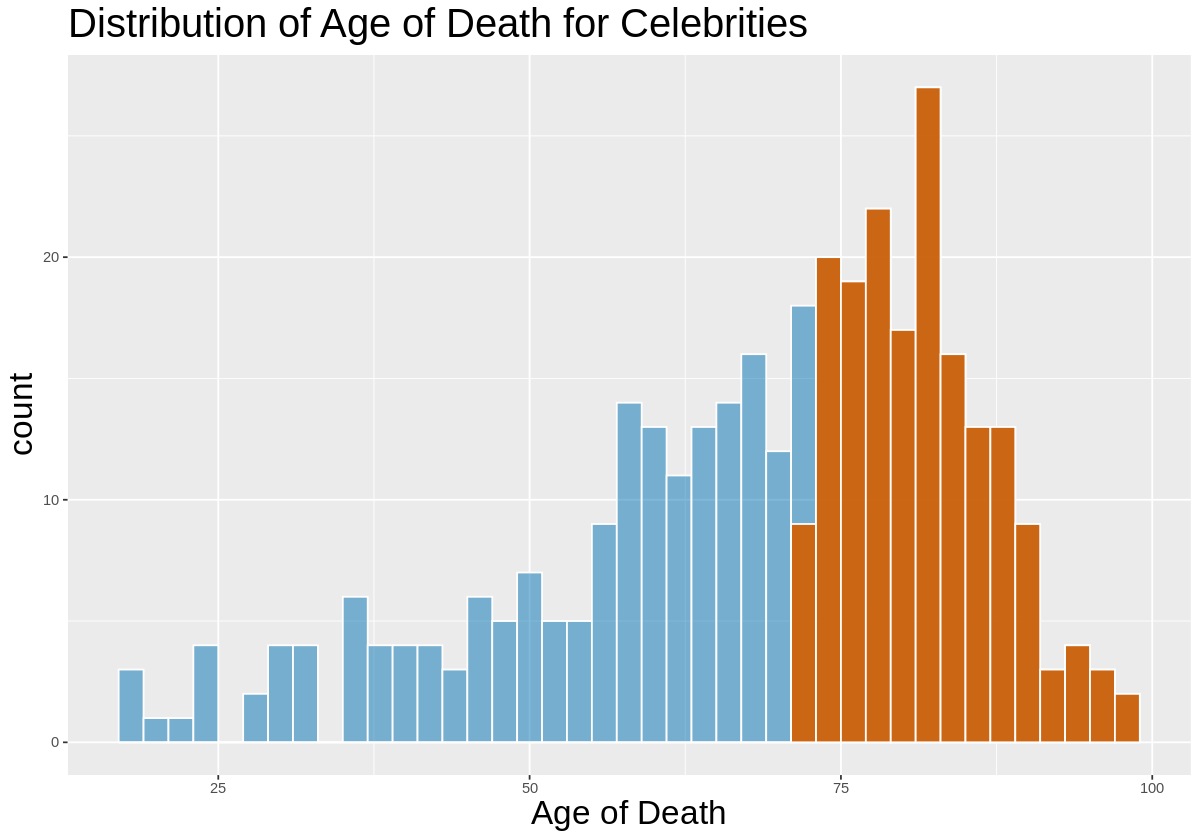

In [28]:
options(repr.plot.width=10, repr.plot.height=7)

plot_prop_srs <- ggplot(age_srs, aes(x = Age.of.death)) + 
    geom_histogram(binwidth = 2, position = "identity", colour = "#FFFFFF", fill = "#0072B2", alpha = 0.5) + 
    geom_histogram(data=subset(age_srs,age_srs$Age.of.death>72.6),binwidth=2, colour = "#FFFFFF", fill = "#D55E00", alpha = 0.9) + 
    xlab("Age of Death") + 
    ggtitle("Distribution of Age of Death for Celebrities") +
    theme(axis.title = element_text(size = 20)) +
    theme(plot.title = element_text(size = 24))
plot_prop_srs

Above is a histogram of the ages of death in our sample. The section of the histogram that is orange contains the observations where age of death is over 72.6. Visually it looks like about 50% of the observations have age of death over 72.6.

Now, let's examine the proportion mathematically.

First we need to verify if we should use the finite population correction factor to make sure the Central Limit Theorem holds. In order to do this, we check if the ratio of sample size to population size is small enough.

In [29]:
nrow(age_srs)/pop_n

[1] 0.0002910853

0.0003 is sufficiently small that we do not need to use the population correction factor. However, it since we know N we can include it to get slighly more accurate results.

The formulas we need to use to calculate a proportion estimate and the confidence interval for proportion are the following:

$${\hat{p} = n_{d}/{n}}$$

$${\text{CI} = \hat{p}} \pm 1.96 \times {\sqrt{(1-n/N)\frac{\hat{p} \times (1-\hat{p})}{n}}}$$


<br>


| Variable | Definition |
| - | :- | 
| $\hat{p}$ | the sample proportion of celebrities that died over the age of 72.6
| $n$ | the number of subjects in our sample
| $n_{d}$ | the number of subjects in our sample that died over the age of 72.6
| $N$ | the number of subjects in our population

In order for the above formulas to hold, we need to check that $np > 10$ and $n(p-1) > 10$. Based on our previous visualization, we can take 0.5 as an approximate proportion value.

In [30]:
nrow(age_srs)*0.5

[1] 178

178 is well above 10 so we can continue with using the proportion confidence interval formulas above.

In order to account for the worst case scenario for standard error, we will replace the $\hat{p}$ values in the standard error with the value 0.5.

In [31]:
proportion_estimate <- age_srs %>%
mutate(over = Age.of.death > 72.6) %>%
summarize(prop = mean(over),
          n = n(),
          se = sqrt((1-n/pop_n)*0.5*0.5/n),
         lower = prop - 1.96 * se,
         upper = prop + 1.96 * se)

In [32]:
proportion_estimate

prop,n,se,lower,upper
<dbl>,<int>,<dbl>,<dbl>,<dbl>
0.497191,356,0.02649609,0.4452587,0.5491233


Our estimate for the proportion of celebrities that die over the age of 72.6, is 0.497. This is an unbiased estimate as $E[\hat{p}] = p$

Our standard error is around 2.6 percentage points. This indicates by how much our sample proportion is likely to deviate from the population proportion.

Our confidence interval for proportion p has a lower bound of 0.445 and an upper bound of 0.549. We can interpret this as: if we take many samples of size n from the same celebrity population and construct a confidence interval for proportion based on each sample using the same formula, about 95% of all these confidence intervals will include the true value p.

As stated previously, the world average life expectancy is around 72.6. Our confidence interval for the proportion of celebrities that die over the age of 72.6 includes 0.5. This indicates that perhaps celebrity median life expectancy does not deviate too much from the 72.6 world life expectancy estimate.

In order to make our conclusions, we have been working under the assumption that the sample data drawn from the population of celebrities is unbiased, representative, independent and identically distributed. Using a simple random sample helps us be confident in this assumption. 

### Proportion with our Stratified Sample

Now, lets examine the proportion of celebrities dying over the age of 72.6 for our stratified sample.

Let's visualize with our stratified sample

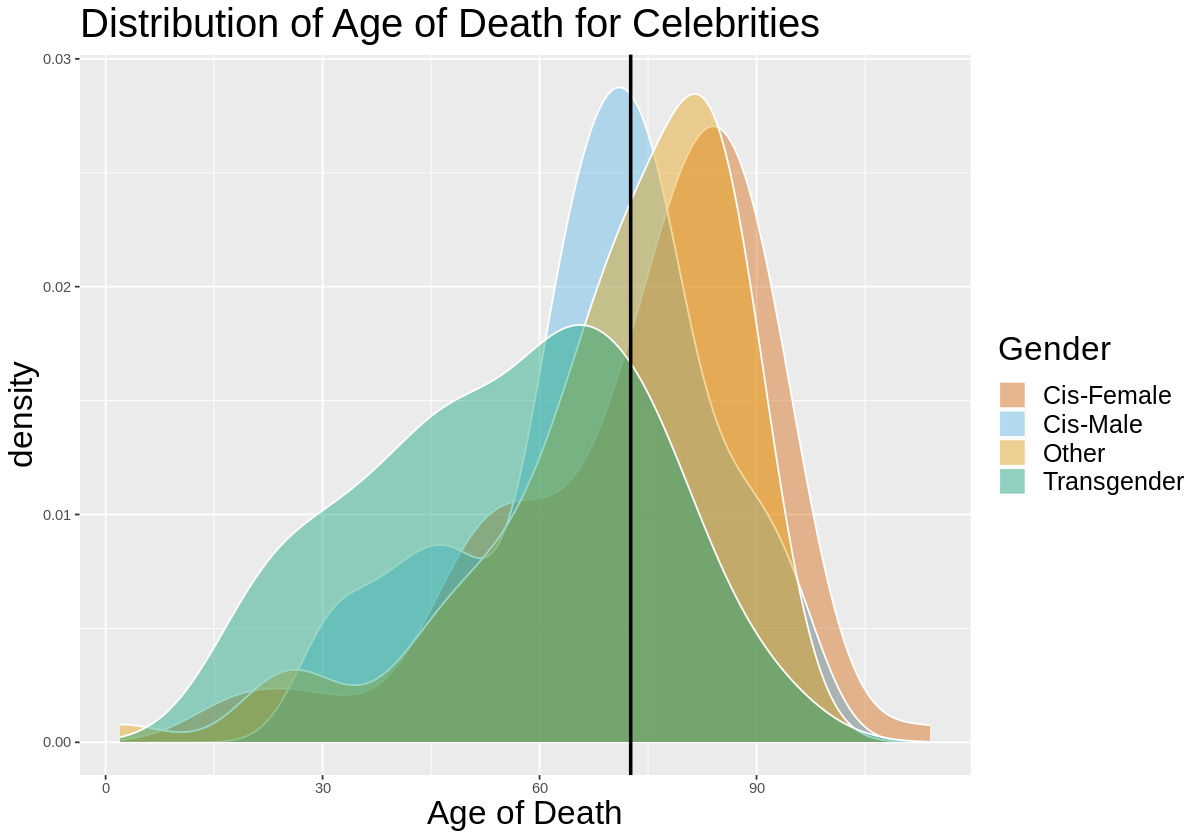

In [33]:
plot_prop_strat <- ggplot(age_strat, aes(x = Age.of.death, fill = Gender)) + 
    geom_density(stat = "density", colour = "#FFFFFF", alpha = 0.4) +
    geom_vline(aes(xintercept = 72.6), linewidth = 1, colour = "#000000") +
    xlab("Age of Death") + 
    ggtitle("Distribution of Age of Death for Celebrities") +
    scale_fill_manual(
        values = c("#D55E0050", "#56B4E950", "#E69F0050", "#009E7350"),
        breaks = c("Cis-Female", "Cis-Male", "Other", "Transgender")
    ) +
    theme(axis.title = element_text(size = 20)) +
    theme(plot.title = element_text(size = 24)) +
    theme(
        legend.title = element_text(size=20), #change legend title font size
        legend.text = element_text(size=15))
plot_prop_strat

Above is a density plot of the ages of death in our sample. The section of the density plot to the right of the black line contains the observations where age of death is over 72.6. This density plot is split by Gender, the variable we used for stratification. Visually it looks like most Transgender people in our sample died before the age of 72.6. Let's say that we don't use weighted averages. Since our stratified sample contains a higher percentage of Transgender people, it is likely that the sample proportion of people who died over the age of 72.6 would be lower than it was for our simple random sample.

Below is the formula for getting our proportion estimate, standard error, and confidence interval now that we have a stratified sample.


$$S_{p} = {\sum\limits_{h}{\frac{N_{h}}{N}} * p_{h}}$$

$$SE = {\sqrt{\sum\limits_{h}(1-{\frac{n_{h}}{N_{h}}})(\frac{N_{h}}{N})^2(\frac{S_{h}^2}{n_{h}})}}$$

$$CI = S_{p} \pm 1.96 \times SE$$

<br>


| Variable | Definition |
| - | :- | 
| $S_{p}$ | sample proportion estimate
| $p_{h}$ | sample proportion estimate in stratum h
| $S_{h}^2$ | sample variance for the sampled units that belong to stratum h
| $N$ | total population size
| $N_{h}$ | number of units (in the population) that belong to stratum h
| $n_{h}$ | number of units sampled that belong to stratum h
| $S_{h}^2$ | sample variance for the sampled units that belong to stratum h
| $SE$ | standard error for our proportion estimate
| $CI$ | confidence interval for our proportion estimate


.

Below we will carry out these calculations. For calculating the proportion and standard error for each stratum, we will use similar techniques to those we used for the simple random sample.

In [34]:
## Strata proportion estimates

strat_proportion_estimate <- age_strat %>%
group_by(Gender) %>%
mutate(over = Age.of.death > 72.6) %>%
summarize(prop = mean(over),
          n = n(),
          var = 0.5*0.5,
          se = sqrt(var/n))

strat_proportion_estimate

Gender,prop,n,var,se
<chr>,<dbl>,<int>,<dbl>,<dbl>
Cis-Female,0.6292135,89,0.25,0.05299989
Cis-Male,0.4157303,89,0.25,0.05299989
Other,0.5505618,89,0.25,0.05299989
Transgender,0.2134831,89,0.25,0.05299989


Since we are using the "worst case" value of 0.5 for calculating the standard error for each stratum, and each stratum has the same size, it makes sense that the variance for proportion for each stratum is the same. There is, however, a clear difference in the proportion estimates between each strata. The sample proportion of Transgender people dying over the age of 72.6 (0.213) seems to be much lower than the sample proportion of Cis-Females, Cis-Males, and Other dying over the age of 72.6 (0.629, 0.416, 0.551). This indicates that Transgender people may have a lower mean age of death compared to Cis-Males and Cis-Females. Due to stratified sampling, we get an estimate of reasonable precision for the Transgender proportion.

In [35]:
## Sample proportion estimate

# Record total population size
N <- nrow(age_df)

# Record number of units that belong to each strata in the population
N_strata <- age_df %>%
group_by(Gender) %>%
summarize(strata_counts = n())

N_strata

Gender,strata_counts
<chr>,<int>
Cis-Female,107831
Cis-Male,981386
Other,133667
Transgender,125


In [36]:
# Calculate proportion estimate
sample_proportion = 0

for (gender in c('Cis-Female', 'Cis-Male','Transgender', 'Other')) {
    Nh = N_strata %>%
filter(Gender == gender)
    p_row = strat_proportion_estimate %>%
 filter(Gender==gender)
    p = p_row[[2]]
    Nh = Nh[[2]]
    sample_proportion = sample_proportion + (Nh/N)*p
}

sample_proportion

[1] 0.4492684

With our stratified sample we get a sample proportion estimate of 0.449. This is lower than our SRS estimate of 0.497. When calculating the standard error, we will need to use the population correction factor since the number of Transgender people in our sample is the same as the number of Transgender people in the population.

In [37]:
### Sample proportion standard error

sum_for_se = 0

for (gender in c('Cis-Female', 'Cis-Male','Transgender', 'Other')) {
    Nh = N_strata %>%
filter(Gender == gender)
    p_gen = strat_proportion_estimate %>%
 filter(Gender==gender)
    p = p_gen[[2]] 
    nh = p_gen[[3]]
    var = p_gen[[4]]
    Nh = Nh[[2]] 
    sum_for_se = sum_for_se + (1-nh/Nh)*(Nh/N)**2*(var/nh)
}

SE = sqrt(sum_for_se)
SE

[1] 0.04317293

Our standard error when we use the stratified sample estimate is slightly larger than the standard error for the SRS estimate (0.026). In this case, our stratefied sample gives a less precise estimate than our simple random sample estimate.

Now that we have an estimate and standard error, we can calculate a confidence interval.

In [38]:
upper_bound = sample_proportion + 1.96*SE
lower_bound = sample_proportion - 1.96*SE
upper_bound
lower_bound

[1] 0.5338873

[1] 0.3646495

We have a confidence interval of (0.365,0.534) for our stratified sample proportion estimate. We can interpret this as: if we take many stratified samples of size n from the same celebrity population and construct a confidence interval for proportion based on each sample using the same formula, about 95% of all these confidence intervals will include the true value p. Our confidence interval for proportion using the stratified sample does include the value 0.5. For our stratified sample, we do not have evidence that celebrity median life expectancy is different than the 72.6 world life expectancy estimate.

For calculating the standard error and confidence interval, we are working under the assumption that each member of the population has been correctly classified into their Gender stratum. This is not necessarily true as there were many missing values, and values with two Genders which were grouped as "Other".

It was interesting to see the different in proportion estimates between the strata. There are only 250 transgender data-points in our data-set of over a million values. So, a major benefit of using stratified sampling is that we got to ensure estimates of reasonable precision for those in the Transgender category. 

### Mean with our Simple Random Sample

Now, lets investigate the mean age of death in our simple random sample. We can start with visualizaion of the vanilla mean estimator.

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


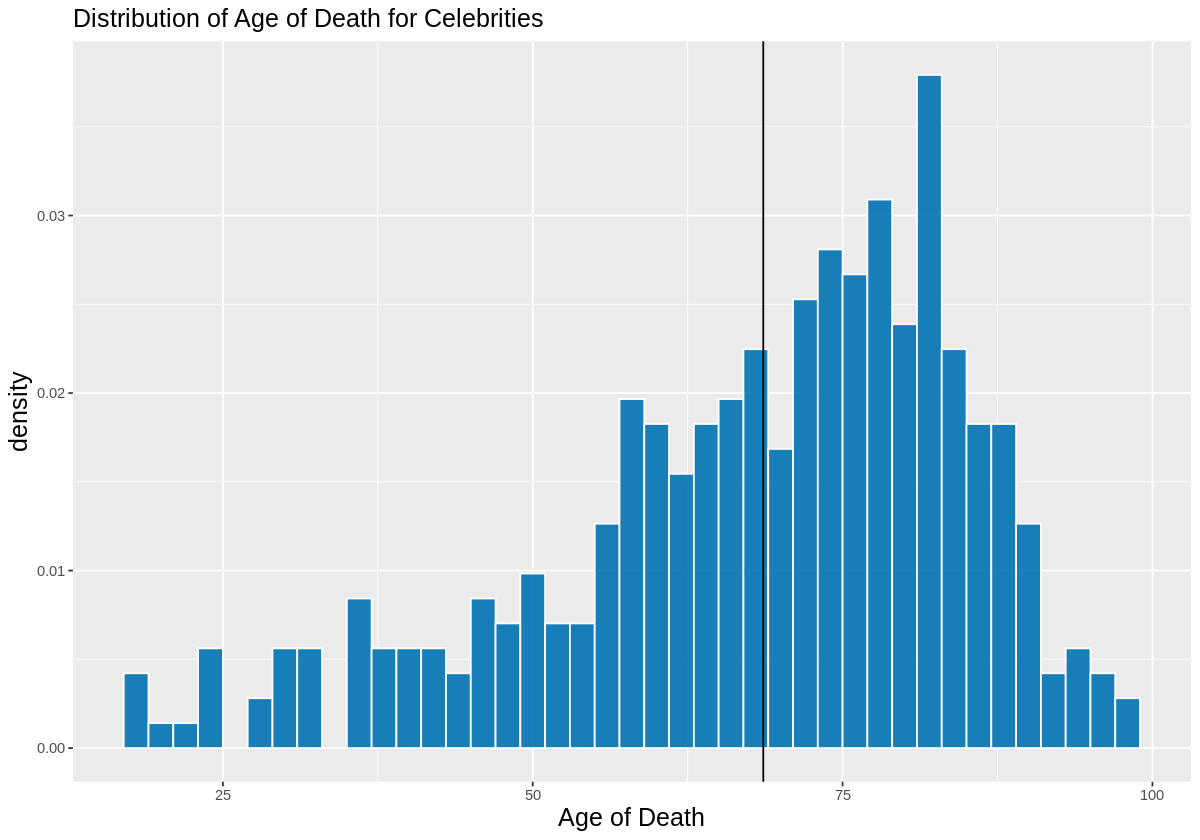

In [39]:
plot_both <- ggplot(age_srs, aes(x = Age.of.death)) + 
    geom_histogram(binwidth = 2, alpha = 0.9, position = "identity", aes(y = ..density..), colour = "#FFFFFF", fill="#0072B2") +
    xlab("Age of Death") + 
    geom_vline(aes(xintercept = mean(Age.of.death))) +
    ggtitle("Distribution of Age of Death for Celebrities") +
    theme(axis.title = element_text(size = 15)) +
    theme(plot.title = element_text(size = 15))
plot_both

It appears that the mean age of death in our simple random sample is around 70. Now, lets check the actual mean estimate, standard error, and confidence interval.

Lets determine whether we should use a vanilla, ratio, or regression estimation for determining the mean. To do this, we will check to see if Age of Death is strongly correlated to any of the other numeric variables in our sample.

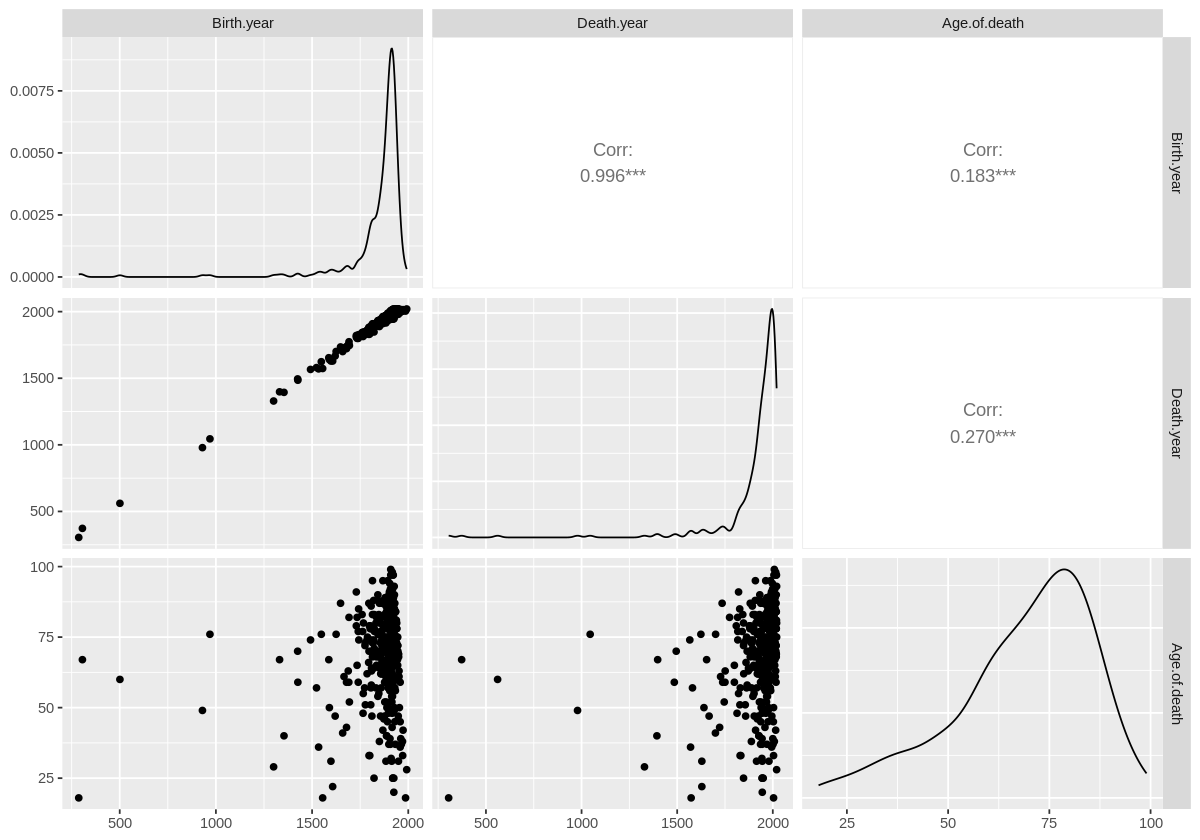

In [40]:
ggpairs(age_srs %>% select(c('Birth.year','Death.year','Age.of.death')))

There is not a strong positive correlation between Age of death and either of the numeric variables in our sample, therefore, we will use a vanilla estimate of the mean.

We can use the following formulas to check the mean estimate, standard error, and confidence interval.

$$\bar{y}_{s} = {\frac{{\sum{y_{i}}}}{n}}$$

$$e_{i} = y_{i} - \bar{y}_{s}$$

$$s_{e} ^ 2 = {\frac{1}{n-1}}*{\sum\limits_{i}{e_{i}^{2}}}$$

$${\text{CI} = \bar{y}_{s}} \pm 1.96 \times {\sqrt{(1-n/N)\frac{s_{e} ^ 2}{n}}}$$


<br>


| Variable | Definition |
| - | :- | 
| $\bar{y}_{s}$ | the sample mean of Age of Death of celebrities
| $n$ | the number of subjects in our sample
| $y_{i}$ | the age of death of the ith celebrity in our sample
| $N$ | the number of subjects in our population

Below we will carry out these calculations.

In [41]:
ei_sum = sum((age_srs$Age.of.death - mean(age_srs$Age.of.death))^2)

means_estimate <- age_srs %>%
reframe(mean = mean(Age.of.death),
          n = n(),
          sample_error_var = (1/(n-1))*ei_sum,
          SE = sqrt((1-n/pop_n)*sample_error_var/n),
          lower = mean - 1.96 * SE,
          upper = mean + 1.96 * SE)
means_estimate

mean,n,sample_error_var,SE,lower,upper
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
68.60112,356,290.5052,0.9032101,66.83083,70.37142


We end up with a sample mean age of death of 68.601.

Our standard error for this estimate is 0.903.

Our confidence interval for this estimate is (66.83,70.37). Overall, this estimate seems to be fairly precise. In addition the width of the confidence interval (3.54) is smaller than the one we were aiming for when we calculated our sample size (5). From this confidence interval, which does not include the age 72.6, it seems there is some evidence that the average age of death of celebrities is not 72.6.

We calculate these values under the assumption that our sample is large enough for the central Limit Theorem to hold. Since our sample is much larger than 30 we can be confident that this assumption holds. We also assume that the observations in our sample are equally likely to be obtained and independent. Since we used a simple random sample we can also be confident that this assumption holds.

### Mean with our Stratified Sample

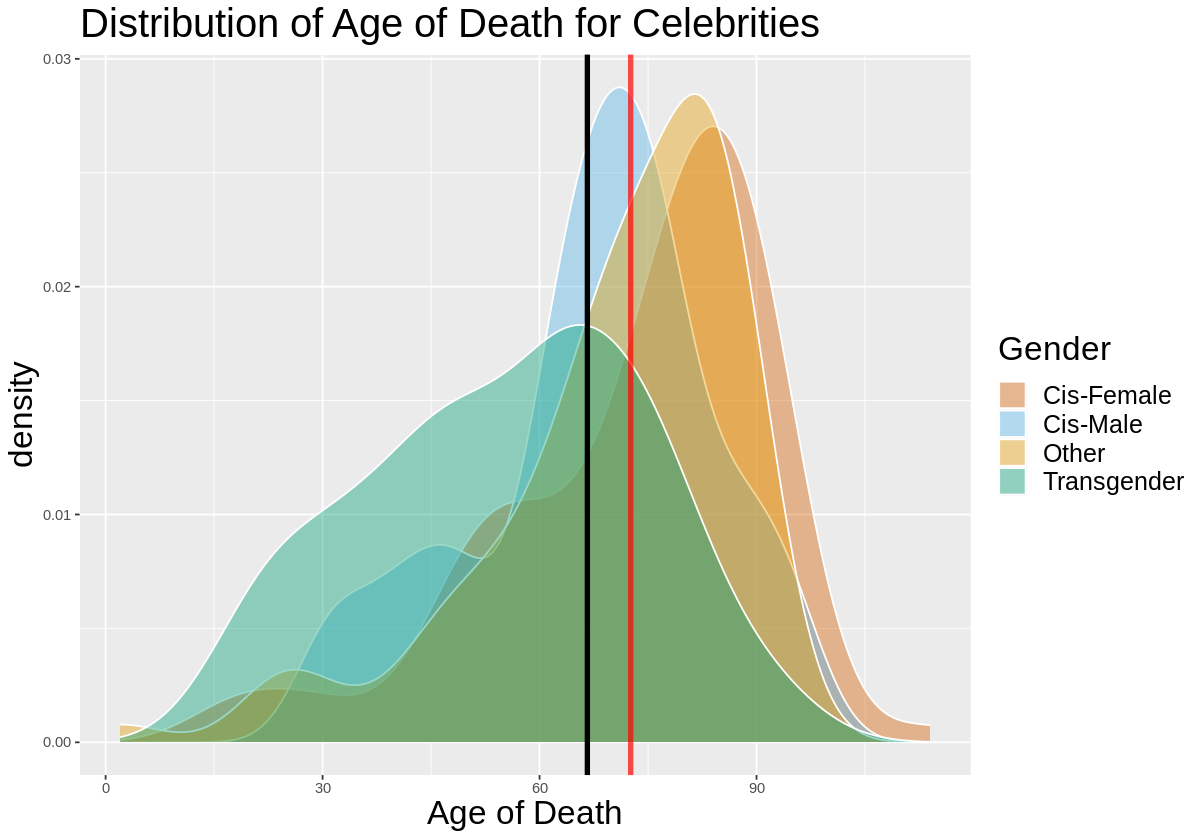

In [42]:
plot_mean_strat <- ggplot(age_strat, aes(x = Age.of.death, fill = Gender)) + 
    geom_density(stat = "density", colour = "#FFFFFF", alpha = 0.4) +
    geom_vline(aes(xintercept = mean(age_strat$Age.of.death)), linewidth = 1.5) +
    geom_vline(aes(xintercept = 72.6), linewidth = 1.5, colour = "#FF0000", alpha = 0.7) +
    xlab("Age of Death") + 
    ggtitle("Distribution of Age of Death for Celebrities") +

    scale_fill_manual(
        values = c("#D55E0050", "#56B4E950", "#E69F0050", "#009E7350"),
        breaks = c("Cis-Female", "Cis-Male", "Other", "Transgender")
    ) +
    theme(axis.title = element_text(size = 20)) +
    theme(plot.title = element_text(size = 24)) +
    theme(
        legend.title = element_text(size=20), #change legend title font size
        legend.text = element_text(size=15))
plot_mean_strat

From this visualization, where we do not use a weighted average to calculate the mean, we can see that the mean age of death (black line) is lower than it was for our simple random sample (red line).


$$\bar y_{str} = {\sum\limits_{h}{\frac{N_{h}}{N}} * \bar y_{Sh}}$$

$$SE\bar y_{str} = {\sqrt{\sum\limits_{h}(1-{\frac{n_{h}}{N_{h}}})(\frac{N_{h}}{N})^2(\frac{S_{h}^2}{n_{h}})}}$$

$$CI = \bar y_{str} \pm 1.96 \times SE\bar y_{str}$$

<br>


| Variable | Definition |
| - | :- | 
| $\bar y_{str}$ | sample mean estimate
| $\bar y_{Sh}$ | sample mean estimate in stratum h
| $S_{h}^2$ | sample variance for the sampled units that belong to stratum h
| $N$ | total population size
| $N_{h}$ | number of units (in the population) that belong to stratum h
| $n_{h}$ | number of units sampled that belong to stratum h
| $S_{h}^2$ | sample variance for the sampled units that belong to stratum h
| $SE\bar y_{str}$ | standard error for our mean estimate
| $CI$ | confidence interval for our proportion estimate


In [43]:
# Calculations

## Strata mean estimates

strat_mean_estimate <- age_strat %>%
group_by(Gender) %>%
summarize(mean = mean(Age.of.death),
          var = var(Age.of.death),
          n = n(),
          SE = sqrt(var/n),
          lower = mean - 1.96 * SE,
          upper = mean + 1.96 * SE)

strat_mean_estimate

Gender,mean,var,n,SE,lower,upper
<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Cis-Female,73.51685,353.1162,89,1.991883,69.61276,77.42094
Cis-Male,67.37079,277.5541,89,1.765952,63.90952,70.83205
Other,70.33708,322.3851,89,1.903235,66.60674,74.06742
Transgender,55.21348,378.2607,89,2.061582,51.17278,59.25418


Interestingly, the sample means vary by quite a lot within each strata. Those who are Transgender in our sample have a much lower mean age of death than those in the other gender sub-categories. Like in our proportion calculations, by doing a stratified sample, we are able to get a fairly precise estimate for the mean age of death of Transgender people in our population.

In [44]:
## Sample mean estimate

sample_mean = 0

for (gender in c('Cis-Female', 'Cis-Male','Transgender','Other')) {
    Nh = N_strata %>%
filter(Gender == gender)
    m_gen = strat_mean_estimate %>%
 filter(Gender==gender)
    m = m_gen[[2]]
    Nh = Nh[[2]]
    sample_mean = sample_mean + (Nh/N)*m
}
sample_mean

[1] 68.23563

Our estimate of 68.2 is actually very close to the estimate achieved with our simple random sample (68.6). This is because our calculations take into account the percentage of each stratum in our population. This estimate may even be more accurate because we are including specific information regarding to the percentage of each gender in the population.

In [45]:
### Sample mean standard error

sum_for_se = 0

for (gender in c('Cis-Female', 'Cis-Male','Transgender','Other')) {
    Nh = N_strata %>%
filter(Gender == gender)
    m_gen = strat_mean_estimate %>%
 filter(Gender==gender)
    m = m_gen[[2]]
    nh = m_gen[[4]]
    var = m_gen[[3]]
    Nh = Nh[[2]]
    sum_for_se = sum_for_se + (1-nh/Nh)*(Nh/N)^2*(var/nh)
}

SE = sqrt(sum_for_se)
SE

[1] 1.442894

Our standard error of about 1.44 is larger than the standard error we calculated for our simple random sample mean estimate (about 0.9). This indicates that our stratified sample estimate is less precise than our simple random sample estimate.

In [46]:
upper_bound = sample_mean + 1.96*SE
lower_bound = sample_mean - 1.96*SE
lower_bound
upper_bound

[1] 65.40756

[1] 71.0637

Our confidence interval is around 5.6, which is close to the width of 5 that we aimed for when calculating our sample size. Also, again our confidence interval does not include the age 72.6, it seems there is no evidence here that celebrities die at an average age of 72.6.

A benefit of using a stratified sample is that we were able to notice interesting patterns within each stratum, while making sure that the final mean estimate was representative of the population.

However, we have calculated these values under the assumption that each member of the population was properly sorted into the Gender sub-groups. This may not be the case as there were many missing values, and values with two Genders which got classified as "Other."

## Conclusion
Overall, the population can be generalized to a larger population since we see that we have a very low standard error which is around 2.2%. We were also able to compare the proportion of deceased celebrities and we saw that we achieved a confidence interval of (69.45, 69.85) from our stratified sample estimate, which is a bit lower than the world average life expectancy of 72.6 years. We also saw that the stratified sample estimate(0.456) is more accurate than our simple random sample mean(0.492). However it can only be generalized with male and female as there was just enough data of other genders to be included in the sample size. 

Furthermore, we saw that the average age of death from our sampling was lower than the world average life expectancy of 72.6 years. This may be due to a few reasons such as: some of the celebrities from our samples could be from previous centuries where the life expectancy is not as high as now due to the fact that medical technology and personal hygiene were not as advanced as today. In addition, Transgender was very socially acceptable until the recent decade or so therefore the average life expectancy will be higher when compared to others where medical services are much more advanced and better. 
